In [4]:
%matplotlib inline  
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

# Part 1: Generating some data
In order to do this lab you're gonna need some data. Holding to the tradition of data science, let's make it up as we go. Using PyTorch's __[built in distribution sampling functions](https://pytorch.org/docs/stable/distributions.html)__ create a dataset sampled from a Bernoulli, and another dataset sampled from a normal distribution

## Sampling from a normal distribution
First, draw a sample from a normal distribution using the parameters below. Store your data in the variable named `X_norm`, and print out the sample mean and standard deviation

In [5]:
from torch.distributions import normal

trueMu = 1.491# mean
trueSig = 0.1876# standard deviation
nNormal = 1000
#### your code here ####


normal_dist = normal.Normal(loc = trueMu, scale = trueSig)
X_norm = normal_dist.sample([nNormal])

**How close are the sample estimates of the mean and standard deviation to the true values? How can you improve the sample estimation of these values? What is the theorem that backs up your answer? Please describe how you might do that below and then implement your solution.** Continue to store your data in the variable `X_norm`.

To improve the sample estimates of the mean and standard deviation, we could increase the sample size. This is the **Law of Large Numbers**

In [3]:
# mean of sample
X_norm.mean()

# std. of sample
X_norm.std()

tensor(0.1858)

## Binary data generation
Follow the same steps as above, but instead of a normal distribution we want binary data. What distribution can you use to sample binary data? Make sure that the sample estimate probability of seeing a value of `1` is close to `trueP`. **Please plot the mean of your sample as you increase n. Say from 10 to 10,000** and confirm that the mean does converge to `trueP`. Remember to store your largest sample in the variable `X_bin`

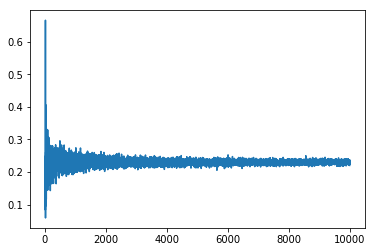

In [4]:
trueP = 0.23

bernoulli_dist = torch.distributions.bernoulli.Bernoulli(probs=trueP)

N, mu = [], []
for n in range(10,10000):
    N.append(n)
    mu.append(bernoulli_dist.sample([n]).mean())
    
plt.plot(N, mu)

# Part 2: Maximum Likelihood Estimation
You'll be learning more about maximum likelihood estimation (MLE) next week, but you'll have a chance to gain some intuition, and see how one can implement MLE here.

In the previous section you learned how more data can help you estimate the parameters of distributions that observations are drawn from. In the example of data drawn from a normal distribution it's intuitive how we can estimate the mean and standard deviation which parameterize the distribution which generated the data. Put another way, given the data we've seen and an idea for the function which generated this data (ie a normal distribution) we want find the parameters that likely describe how this data was generated. 

Let's examine some of the moving parts. We have some data, $X \in R^{n}$, and we know that each observation $x^{i}$ was generated with probability defined by $f(x^{i};\theta)$ where $\theta$ are the parameters that help us define this function. I know this is a little handwavy but just bear with me here. You'll get a better theoretical understanding in class. Let's look at the example of the normal distribution as a data generating function. Here $f(x^{i};\theta) = f(x^{i};\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(x^{i}-\mu)^2}{2\sigma^2})$ which is the probability density function of the __[normal distribution](https://en.wikipedia.org/wiki/Normal_distribution)__. 

So that's the probability of observing one $x^i$, but what about all $n$ of those dudes? Well since we're dealing with indpendently and identically distributed data (or independent trials of data drawn from the same distribution) we just multiply that function over and over to get the likelihood of observing our data. Recall that $f(X;\mu, \sigma) = f(x^1, x^2,...,x^n;\mu, \sigma)$ is a joint distribution over all the variables in $X$. Because of independence this joint can be rewritten as the product of the likelihood of every $x^i$. That is $f(X;\mu, \sigma) = \prod_{i = 1}^{n}f(x^{i}|\mu, \sigma) = \frac{1}{2\pi\sigma^2}^{\frac{n}{2}}exp(-\frac{\sum_{i=1}^{n}(x^{i}-\mu)^2}{2\sigma^2})$. The last step skips over some algebra when multiplying the probability density function of the normal $n$ times. 

Ok, so that was alot. But essentially we're just deriving the probability of seeing all our data. The next and final step is to take the log of the final equation above. We do this because of numerical stability. When you're dealing with small numbers, like fractions, repeatedly muliplying them can lead to underflow. $$L(X;\mu, \sigma) = \frac{-n}{2}log(2\pi\sigma^2) - \frac{1}{2\pi\sigma^2}\sum_{i=1}^{n}(x^i - \mu)^2$$

During MLE our goal is to find the parameters $\theta$ which maximize the function $L(X;\theta)$. In the cell below fix $\sigma$ at the true value of `0.1876` and calculate the likelihood function for the data observed with varied $\mu$ between 1 and 2 with a step size of 0.05. Which value of $\mu$ maximizes the function?

In [5]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

def MLE(X, truSig):
    # evaluate the likelihood of the observed vector given a range of mu's
    likelihoodList, muList = [], []
    for mu in frange(1,2,0.001):
        likelihood_est = []
        
        # estimate the likelihood of each observed number GIVEN mu
        for x in X:
            likelihood_est.append(0.5*np.log(2*math.pi*(truSig**2)) - 1/2*math.pi*(truSig*truSig) - ((x - mu)**2))
    
        likelihoodList.append(sum(likelihood_est))
        muList.append(mu)
        
    index = likelihoodList.index(max(likelihoodList))
    return muList[index]


truSig = 0.1876
MLE(X = X_norm, truSig = 0.1876)

1.498999999999945

## MLE: Normal
So from above we can see that at the true values of $\sigma$ and $\mu$ the log likelihood is maximized. How can we learn what these parameters should be in order to maximize the MLE? With a little PyTorch and gradient descent we can do just that.

## Tensors, Variables and Computational graphs
Insert Wizard of Oz "Oh my" joke here. Ok, moving on. If we're going to learn the parameters which maximize the MLE, we need to know which parameters to maximize, and how to run the MLE function as well as how to perform back propagation. Let's look at each of these pieces separately. 

### Tensors
You can kind of think of Tensors and PyTorch's specialized NumPy matrices. How are they like NumPy matrices? They... well... they can hold values in a matrix (single or multidimensional) format. And how are the specialized? Unlike NumPy matrices Tensors can make use of GPU resources to significantly speed up matrix operations, which make up a bulk of what you need to do in deep learning.

### Variables (or Tensors with a gradient)
It used to be that PyTorch had a separate object called a Variable which were just like Tensors, except they're meant to hold values which will change as we learn their optimal or "true" value. In the most current version of PyTroch these two objects have been merged into the Tensor object. When you have a Tensor which needs to store data, but also needs to be updated as we learn its optimal or "true" value you create a tensor but require that the gradient be stored. You'll see this in the code below.

Tensors hold onto a few important attributes which you can access through `Tensor.grad.data` and `Tensor.data`. One holds onto the actual values of the object, while the other holds onto the gradient. As we learn more about machine learning in this class the reason why these two pieces of information are important will become clear. One important thing to know is that every time a variable is back propogated through the gradient **accumulates** and is not replaced so you have to manually zero out the gradient with `Tensorgrad.data.zero_()`.


### Computational graphs
Computational graphs are structures which store chains of multiplications, additions, and other math functions (sin, exponential, log, Hadamard product, etc) in such a way that calculating the gradient via the chain rule is simple. Again, you will learn more about why it's important for us to do this in the future, but for now all you need to know is that PyTorch creates computational graphs which allow you to easily calculate the derivative using the chain rule. 

A computational graph is created only once you run code which starts applying math functions, multiplications, and additions to Tensors. This means it's a dynamic computation graph. And once you calculate the derivative using a backward pass it's destroyed, meaning that all the information needed to calculate the derivatives is gone. There's more to this, but if you want to learn more about it I would suggest this __[video](https://www.youtube.com/watch?v=nbJ-2G2GXL0)__ and this __[site](https://towardsdatascience.com/getting-started-with-pytorch-part-1-understanding-how-automatic-differentiation-works-5008282073ec)__.

## An example 
Let's see some of this in action. I've implemented code to learn how to maximize the MLE for data drawn from a normal distribution by learning the best $\mu$ and $\sigma$ parameters. But let's face it, it's gonna take me a while to figure out what I'm doing. So there are 4 versions of code below. All but the last one has a bug in it that prevents it from doing what we want. **Identify the bug in each version, and what needs to be fixed**. Of course you can peak ahead to see what changed, but looking at each version by itself before moving on to the next will be helpful for future debugging sessions.

Tip: The third example might be kind of hard to spot because the code runs, but it never learns anything. Why might this be? What's going on with the gradient?

### MLE for normally distributed data: Version 1
#### What went wrong?

In [7]:
# Taking our randomly generated data and wrapping it in a Variable call
# When we set requires_grad=False this means that we don't want to update these parameters
# and don't need to compute gradients with respect to these Variables. .
x = torch.autograd.Variable(X_norm, requires_grad=True)


# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the the MLE.
learnedMu = torch.rand(1, requires_grad = True)
learnedSigma = torch.rand(1, requires_grad = True)
print("Initial Mu: {}".format(learnedMu))
print("Initial Sigma: {}".format(learnedSigma))


# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.000001
# learnedProb.zero_()
n = X_norm.shape[0]
#Instantiate the MLE for a normal distribution here using torch functions.
MLE = -((n/2)*torch.log(2*np.pi*(learnedSigma**2)) + (1/(2*(learnedSigma**2)))*torch.sum((X_norm - learnedMu)**2))
for myIter in range(1000):
    MLE.backward()
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned mu = {}, learned sigma {}".format(MLE.data.numpy(),
                                                                          learnedMu.data.numpy(),
                                                                          learnedSigma.data.numpy()))
        
    # SGD update for our learned parameters
    learnedMu.data = learnedMu.data + learnedMu.grad.data*learningRate
    learnedSigma.data = learnedSigma.data + learnedSigma.grad.data*learningRate

Initial Mu: tensor([0.0895], requires_grad=True)
Initial Sigma: tensor([0.8170], requires_grad=True)
log likelihood: [-2207.212], learned mu = [0.08950484], learned sigma [0.8169567]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

### MLE for normally distributed data: Version 2
#### What went wrong?


In [8]:
# Taking our randomly generated data and wrapping it in a Variable call
# When we set requires_grad=False this means that we don't want to update these parameters
# and don't need to compute gradients with respect to these Variables. .
x = torch.autograd.Variable(X_norm, requires_grad=False)


# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the the MLE.
learnedMu = torch.rand(1, requires_grad = True)
learnedSigma = torch.rand(1, requires_grad = True)
print("Initial Mu: {}".format(learnedMu))
print("Initial Sigma: {}".format(learnedSigma))


# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.000001
# learnedProb.zero_()
n = X_norm.shape[0]
#Instantiate the MLE for a normal distribution here using torch functions.
MLE = -((n/2)*torch.log(2*np.pi*(learnedSigma**2)) + (1/(2*(learnedSigma**2)))*torch.sum((X_norm - learnedMu)**2))
for myIter in range(1000):
    MLE.backward()
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned mu = {}, learned sigma {}".format(MLE.data.numpy(),
                                                                          learnedMu.data.numpy(),
                                                                          learnedSigma.data.numpy()))
    # SGD update for our learned parameters
    learnedMu.data = learnedMu.data + learnedMu.grad.data*learningRate
    learnedSigma.data = learnedSigma.data + learnedSigma.grad.data*learningRate

Initial Mu: tensor([0.5995], requires_grad=True)
Initial Sigma: tensor([0.0468], requires_grad=True)
log likelihood: [-185520.06], learned mu = [0.5994688], learned sigma [0.04684776]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

### MLE for normally distributed data: Version 3
#### What went wrong?


In [14]:
# Taking our randomly generated data and wrapping it in a Variable call
# When we set requires_grad=False this means that we don't want to update these parameters
# and don't need to compute gradients with respect to these Variables. .
x = torch.autograd.Variable(X_norm, requires_grad=False)


# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the the MLE.
learnedMu = torch.rand(1, requires_grad = True)
learnedSigma = torch.rand(1, requires_grad = True)
print("Initial Mu: {}".format(learnedMu))
print("Initial Sigma: {}".format(learnedSigma))


# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.00001
# learnedProb.zero_()
n = X_norm.shape[0]
for myIter in range(1000):
    #Instantiate the MLE for a normal distribution here using torch functions.
    MLE = -((n/2)*torch.log(2*np.pi*(learnedSigma**2)) + (1/(2*(learnedSigma**2)))*torch.sum((X_norm - learnedMu)**2))
    # computes the derivative on the MLE (arguments required for non-scalars)
    MLE.backward()
    
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned mu = {}, learned sigma {}".format(MLE.data.numpy(),
                                                                          learnedMu.data.numpy(),
                                                                          learnedSigma.data.numpy()))
    # SGD update for our learned parameters
    learnedMu.data = learnedMu.data + learnedMu.grad.data*learningRate
    learnedSigma.data = learnedSigma.data + learnedSigma.grad.data*learningRate
    
    # Clear out the gradient information
    learnedMu.grad.data.zero_()
    learnedSigma.grad.data.zero_()

Initial Mu: tensor([0.1832], requires_grad=True)
Initial Sigma: tensor([0.6837], requires_grad=True)
log likelihood: [-2395.7485], learned mu = [0.18319565], learned sigma [0.6837497]
log likelihood: [-410.60504], learned mu = [1.2467116], learned sigma [0.4988375]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]
log likelihood: [254.87772], learned mu = [1.4874781], learned sigma [0.18753003]


### MLE for normally distributed data: Version 4


In [15]:
# Taking our randomly generated data and wrapping it in a Variable call
# When we set requires_grad=False this means that we don't want to update these parameters
# and don't need to compute gradients with respect to these Variables. .
x = torch.autograd.Variable(X_norm, requires_grad=False)

# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the MLE.
learnedMu = torch.rand(1, requires_grad = True)
learnedSigma = torch.rand(1, requires_grad = True)
print("Initial Mu: {}".format(learnedMu))
print("Initial Sigma: {}".format(learnedSigma))

# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.000001
# learnedProb.zero_()
n = X_norm.shape[0]
for myIter in range(1000):
    #Instantiate the MLE for a normal distribution here using torch functions.
    MLE = -((n/2)*torch.log(2*np.pi*(learnedSigma**2)) + (1/(2*(learnedSigma**2)))*torch.sum((X_norm - learnedMu)**2))
    MLE.backward()
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned mu = {}, learned sigma {}".format(MLE.data.numpy(),
                                                                          learnedMu.data.numpy(),
                                                                          learnedSigma.data.numpy()))
    # SGD update for our learned parameters
    learnedMu.data = learnedMu.data + learnedMu.grad.data*learningRate
    learnedSigma.data = learnedSigma.data + learnedSigma.grad.data*learningRate
    # Clear out the gradient information
    learnedMu.grad.data.zero_()
    learnedSigma.grad.data.zero_()

Initial Mu: tensor([0.2935], requires_grad=True)
Initial Sigma: tensor([0.1176], requires_grad=True)
log likelihood: [-51579.707], learned mu = [0.29346043], learned sigma [0.11761582]
log likelihood: [-1442.1178], learned mu = [0.48137885], learned sigma [1.0186422]
log likelihood: [-1355.0919], learned mu = [0.5742584], learned sigma [1.0113331]
log likelihood: [-1275.4534], learned mu = [0.6608977], learned sigma [0.9902608]
log likelihood: [-1196.769], learned mu = [0.7434682], learned sigma [0.95800716]
log likelihood: [-1114.7399], learned mu = [0.82350075], learned sigma [0.9157205]
log likelihood: [-1025.5133], learned mu = [0.9022334], learned sigma [0.8636316]
log likelihood: [-924.6259], learned mu = [0.98082495], learned sigma [0.8011927]
log likelihood: [-805.7887], learned mu = [1.0605413], learned sigma [0.7269671]
log likelihood: [-658.69226], learned mu = [1.1430044], learned sigma [0.6382165]


## MLE: Bernoulli
Finally, using the binary data we generated using a Bernoulli distribution let's learn the true value for $p$. Similarly to the above formulation you'll need to create a parameter to learn, as well as define the MLE for our binary data.

In [51]:
trueP = 0.23
X_benoulli = torch.distributions.bernoulli.Bernoulli(probs=trueP).sample([100])

In [61]:
# We'll wrap our randomly generated data in a Variable call
# Setting requires_grad=False means that we don't want to update these parameters
# and don't need to compute gradients with respect to these Variables 
x = torch.autograd.Variable(X_benoulli, requires_grad = False)

# Instantiate the parameters to learn. Notice how requires_grad is set to true. This is because we want
# to update this parameter with the MLE.
learnedP = torch.rand(1, requires_grad = True)
print("Initial Mu: {}".format(learnedP))

# This says how big of a step should we take each time we update our parameters.
# there is some instability in the updates, so you might have to run a couple of times to get
# values that look like what they should be.
learningRate = 0.0001
n = X_benoulli.shape[0]

for myIter in range(1000):
    #Instantiate the MLE for a normal distribution here using torch functions.
    MLE = ((learnedP)**torch.sum(x))*((1-learnedP)**(x_length - torch.sum(x)))
    MLE.backward()
    # Now we run over the data multiple times, and each time we calculate how far away we are from
    # the maximized MLE and update our parameters accordingly
    if myIter % 100 == 0:
        print("log likelihood: {}, learned p = {}".format(MLE.data.numpy(),
                                                          learnedP.data.numpy()))
    # SGD update for our learned parameters
    learnedP.data = learnedP.data + learnedP.grad.data*learningRate
    # Clear out the gradient information
    learnedP.grad.data.zero_()


Initial Mu: tensor([0.9576], requires_grad=True)
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
log likelihood: [0.], learned p = [0.9575607]
